# A/B тестирование Лендинговой страницы

## 1. Введение

### Цель проведения A/B-теста

Целью этого A/B-теста является определение того, улучшает ли новая лендинговая страница коэффициент конверсии по сравнению с существующей лендинговой страницей. Коэффициент конверсии определяется как процент пользователей, которые решают заплатить за продукт компании после посещения лендинговой страницы. Есть ли межстрановые различия в поведении пользователей.

### Данные

Данные с сайта Kaggle.com https://www.kaggle.com/datasets/ahmedmohameddawoud/ecommerce-ab-testing

- id - уникальный идентификатор пользователя
- time -  время посещения страницы
- con_treat - контрольная или тестовая группы
- page - какая версия страницы показывалась
- converted - совершил пользователь покупку или нет
- country - страна пользователя

## 2. Предобратботка данных

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil, sqrt
import numpy as np

In [142]:
df = pd.read_csv('ab_test.csv')
df_countries = pd.read_csv('countries_ab.csv')

In [143]:
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [144]:
df.shape

(294478, 5)

In [145]:
# переименуем con_treat в group
df = df.rename(columns={'con_treat': 'group'})

In [146]:
df_countries.head()

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [147]:
# Создадим единый датафрейм с детализацией по странам
df = df.merge(df_countries, how='left', left_on='id', right_on='id')
df.head()

,id,time,group,page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [148]:
df.shape

(294478, 6)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   group      294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
 5   country    294478 non-null  object
dtypes: int64(2), object(4)
memory usage: 15.7+ MB


In [150]:
# Проверим полноту данных
df.isnull().sum()

id           0
time         0
group        0
page         0
converted    0
country      0
dtype: int64

#### Какие значения есть в данных

In [151]:
# Типы групп
df.group.unique()

array(['control', 'treatment'], dtype=object)

In [152]:
# Типы страниц
df.page.unique()

array(['old_page', 'new_page'], dtype=object)

In [153]:
# варианты converted
df.converted.unique()

array([0, 1], dtype=int64)

In [154]:
# по каким странам собраны наблюдения
df.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

#### Дубликаты

In [155]:
# Проверим, есть ли дубликаты в данных для пользователей
df['id'].duplicated().any()

True

In [156]:
# Посмотрим, какие дубликаты встречаются
df[df.duplicated('id') == True]

,id,time,group,page,converted,country
2656,698120,13:42.6,control,old_page,0,US
2893,773192,55:59.6,treatment,new_page,0,US
7500,899953,06:54.1,control,new_page,0,CA
8036,790934,32:20.3,treatment,new_page,0,US
10218,633793,16:00.7,treatment,old_page,0,US
...,...,...,...,...,...,...
294308,905197,56:47.5,treatment,new_page,0,UK
294309,787083,15:21.0,control,old_page,0,US
294328,641570,59:27.7,control,old_page,0,UK
294331,689637,34:28.3,control,new_page,0,CA


In [157]:
# Проверим сколько дубликатов в данных
df[df.duplicated('id') == True].count()

id           3894
time         3894
group        3894
page         3894
converted    3894
country      3894
dtype: int64

In [158]:
df[df['id'] == 698120]

,id,time,group,page,converted,country
988,698120,09:37.5,control,new_page,0,US
2656,698120,13:42.6,control,old_page,0,US


In [159]:
df[df['id'] == 773192]

,id,time,group,page,converted,country
1899,773192,37:58.8,treatment,new_page,0,US
2893,773192,55:59.6,treatment,new_page,0,US


In [160]:
df[df['id'] == 899953]

,id,time,group,page,converted,country
3489,899953,36:02.1,treatment,new_page,0,CA
7500,899953,06:54.1,control,new_page,0,CA


In [161]:
# Оставим тех пользователей, кто в группе treatment и кому показали new_page, и тех, кто в группе control и кому показали old_page
df = df[((df['group']=='treatment') & (df['page']=='new_page')) | ((df['group']=='control') & (df['page']=='old_page'))]

In [162]:
# В дубликатах должны были остаться только те варианты, где одному пользователю была показана одна и та же страница несколько раз
df[df.duplicated('id') == True]

,id,time,group,page,converted,country
2893,773192,55:59.6,treatment,new_page,0,US


In [163]:
df[df['id'] == 773192]

,id,time,group,page,converted,country
1899,773192,37:58.8,treatment,new_page,0,US
2893,773192,55:59.6,treatment,new_page,0,US


In [164]:
# удалим дубликаты, оставив последний из просмотров
df = df.drop_duplicates(subset='id', keep='last')

In [165]:
# проверка, остались ли дубликаты
df[df.duplicated('id') == True]

,id,time,group,page,converted,country


## 3. Исследовательский анализ данных

In [166]:
# посмотрим сколько наблюдений в каждой группе сделало платное действие
df_by_group_converted = df.groupby(['group', 'converted']).agg({'id': 'count'}).rename(columns={'id': 'quantity'}).reset_index()
df_by_group_converted

,group,converted,quantity
0,control,0,127785
1,control,1,17489
2,treatment,0,128046
3,treatment,1,17264


In [167]:
total_num = df_by_group_converted.quantity.sum()
control_num = df_by_group_converted.iloc[0, 2] + df_by_group_converted.iloc[1, 2]
treatment_num = df_by_group_converted.iloc[2, 2] + df_by_group_converted.iloc[3, 2]
converted_control_percent = df_by_group_converted.iloc[1, 2] / control_num * 100 
converted_treatment_percent = df_by_group_converted.iloc[3, 2] / treatment_num * 100

In [168]:
print(f'В выборке всего {total_num} наблюдений, из которых {control_num} относятся к котрольной группе и {treatment_num} к тестовой, \
что составляет {(control_num/total_num * 100).round(2)}% и {(treatment_num/total_num * 100).round(2)}% соответственно.') 
print(f'В контрольной выборке {converted_control_percent.round(4)}% пользователей совершили платное действие, в тестовой \
- {converted_treatment_percent.round(4)}%.')

В выборке всего 290584 наблюдений, из которых 145274 относятся к котрольной группе и 145310 к тестовой, что составляет 49.99% и 50.01% соответственно.
В контрольной выборке 12.0386% пользователей совершили платное действие, в тестовой - 11.8808%.


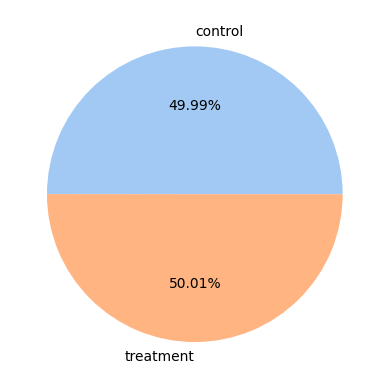

In [173]:
# круговая диаграмма для визуализации распределения наблюдений по группам
colors = sns.color_palette('pastel')[0:2]
plt.pie([control_num/total_num, treatment_num/total_num], labels = ['control', 'treatment'], colors = colors, autopct='%.2f%%')
plt.show()

In [175]:
df_by_country = df.groupby(['country']).agg({'id': 'count'}).rename(columns={'id': 'quantity'}).reset_index()
df_by_country

,country,quantity
0,CA,14499
1,UK,72466
2,US,203619


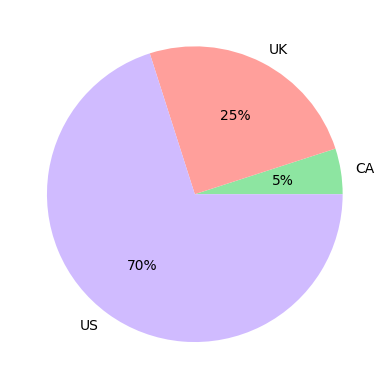

In [183]:
colors = sns.color_palette('pastel')[2:3]
plt.pie([df_by_country.iloc[0,1]/total_num, df_by_country.iloc[1,1]/total_num, df_by_country.iloc[2,1]/total_num], labels = ['CA', 'UK', 'US'], colors = colors, autopct='%.2f%%')
plt.show()

#### Конверсия по странам в разных группах

In [191]:
df_by_country_group = df.groupby(['country', 'group', 'converted']).agg({'id': 'count'}).rename(columns={'id': 'quantity'}).reset_index()
df_by_country_group['quantity_lag'] = df_by_country_group.groupby(['country', 'group'])['quantity'].shift(-1)
df_by_country_group['conversion'] = df_by_country_group['quantity_lag'] / df_by_country_group['quantity']
df_by_country_group

,country,group,converted,quantity,quantity_lag,conversion
0,CA,control,0,6343,855.0,0.134794
1,CA,control,1,855,NaN,NaN
2,CA,treatment,0,6484,817.0,0.126002
3,CA,treatment,1,817,NaN,NaN
4,UK,control,0,31996,4364.0,0.136392
5,UK,control,1,4364,NaN,NaN
6,UK,treatment,0,31731,4375.0,0.137878
7,UK,treatment,1,4375,NaN,NaN
8,US,control,0,89446,12270.0,0.137178
9,US,control,1,12270,NaN,NaN


C:\Users\Anastasia\PycharmProjects\pythonProject\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


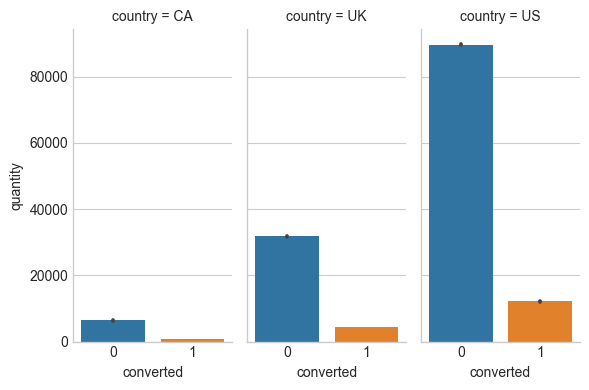

In [241]:
sns.catplot(
    df_by_country_group, kind="bar",
    x="converted", y="quantity", col="country",
    height=4, aspect=.5,
)

#### Доля пользователей по странам в каждой из групп

#### Контрольная группа

In [214]:
df_control = df[df['group'] == 'control']

In [231]:
df_control_by_county = df_control.groupby('country').agg({'id': 'count'}).rename(columns={'id': 'quantity'}).reset_index()
df_control_by_county['percent_from_total_control'] = (df_control_by_county['quantity'] / df_control_by_county['quantity'] .sum() * 100).round(2)
df_control_by_county

,country,quantity,percent_from_total_control
0,CA,7198,4.95
1,UK,36360,25.03
2,US,101716,70.02


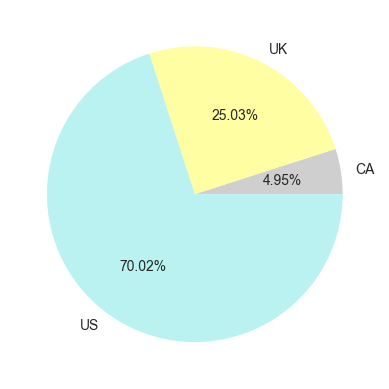

In [265]:
colors = sns.color_palette('pastel')[7:10]
plt.pie(df_control_by_county['quantity'].to_list(), labels = ['CA', 'UK', 'US'], colors = colors, autopct='%.2f%%')
plt.show()

#### Тестовая группа

In [233]:
df_treatment = df[df['group'] == 'treatment']
df_treatment_by_county = df_control.groupby('country').agg({'id': 'count'}).rename(columns={'id': 'quantity'}).reset_index()
df_treatment_by_county['percent_from_total_treatment'] = (df_treatment_by_county['quantity'] / df_control_by_county['quantity'] .sum() * 100).round(2)
df_treatment_by_county

,country,quantity,percent_from_total_treatment
0,CA,7198,4.95
1,UK,36360,25.03
2,US,101716,70.02


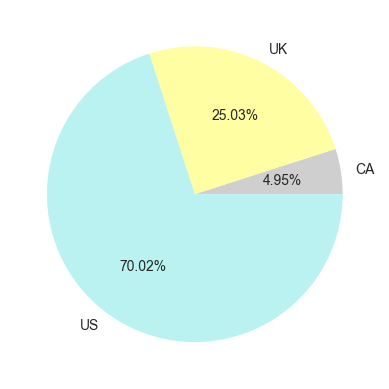

In [266]:
plt.pie(df_control_by_county['quantity'].to_list(), labels = ['CA', 'UK', 'US'], colors = colors, autopct='%.2f%%')
plt.show()

In [240]:
df_share = df_control_by_county.merge(df_treatment_by_county, how='inner', left_on='country', right_on='country')\
[['country', 'percent_from_total_control', 'percent_from_total_treatment']].\
rename(columns={'percent_from_total_control': 'control, %', 'percent_from_total_treatment': 'treatment, %'})
df_share

# Процент наблюдений в каждой группе по странам от общего количества наблюдений в группе

,country,"control, %","treatment, %"
0,CA,4.95,4.95
1,UK,25.03,25.03
2,US,70.02,70.02


Нет межстрановых различий в двух выборках, в каждую из групп попал одинаковый процент наблюдений в зависимости от страны пользователя

## 4. A/B Testing

#### Достаточно ли наблюдений

In [267]:
alpha = 0.05  # уровень значимости
power = 0.80  # мощность теста
p1 = converted_control_percent / 100     # текущая конверсия (контрольная группа)
effect = 0.01 # ожидемый эффект
p2 = p1 + effect  # конверсии в тестовой группе

# Критические значения Z
z_alpha = stats.norm.ppf(1 - alpha / 2)  # Z для двустороннего теста
z_beta = stats.norm.ppf(power)             # Z для мощности

# Расчет размера выборки
numerator = (z_alpha + z_beta) ** 2 * (p1 * (1 - p1) + p2 * (1 - p2))
denominator = (p2 - p1) ** 2
sample_size = numerator / denominator

# Поскольку мы хотим количество участников для каждой группы
total_sample_size = int(np.ceil(sample_size))

print(f'Необходимый размер выборки для каждой группы: {total_sample_size}')
print(f'Общий необходимый размер выборки: {total_sample_size * 2}')

Необходимый размер выборки для каждой группы: 17211
Общий необходимый размер выборки: 34422


In [251]:
print(f'Количество наблюдений в нашей выборке {total_num} превышает минимально необходимое количество наблюдений {total_sample_size * 2}\
 для отслеживания измерений в 1%')

Количество наблюдений в нашей выборке 290584 превышает минимально необходимое количество наблюдений 34422 для отслеживания измерений в 1%


#### Гипотезы

In [263]:
print(f'Конверсия для группы контрольной группы: {converted_control_percent / 100}')
print(f'Конверсия для группы тестовой группы: {converted_treatment_percent / 100}')

# рассчитаем конверсию в комбинированном датасете
conversion_combined = (sum(df['converted']))/(df['id'].count())

# рассчитаем разницу пропорций
difference = converted_control_percent/ 100 - converted_treatment_percent/100

# рассчитаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / sqrt(conversion_combined * (1 - conversion_combined) * 
                                    (1/control_num + 1/treatment_num))
distr = stats.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-value: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между значениями есть значимая разница')
else:
    print('Не можем отвергнуть нулевую гипотезу, нет оснований считать значения разными') 

Конверсия для группы контрольной группы: 0.12038630450046121
Конверсия для группы тестовой группы: 0.11880806551510564
p-значение:  0.18988337448194703
Не можем отвергнуть нулевую гипотезу, нет оснований считать значения разными


## 5. Выводы

Полученное p-value равно 0,19 и превышает пороговое значение альфа = 0,05, не  можем отвергнуть нулевую гипотезу о равенстве конверсий для новой и сторой лендинговых страниц.

Рекомендации:
1) Оставить старую лендинговую страницу
2) Внести новые изменения на странице и продолжить исследования (в зависимости от стоимости эксперимента)
3) Можно продолжить исследования с посмотреть, если ли разница в конверсии для конкретных стран. Для Канады выборка не достаточная для отслеживания изменений в 1%, но для США и Великобритании достаточно наблюдений для проведения теста. Возможно есть межстрановые особенности в поведении пользователей и для одной из стран конверсия для новой страницы будет отличаться от старой.
Полученное p-value равно 0,19 и превышает пороговое значение альфа = 0,05, не  можем отвергнуть нулевую гипотезу о равенстве конверсий для новой и сторой лендинговых страниц.

Рекомендации:
1) Оставить старую лендинговую страницу
2) Внести новые изменения на странице и продолжить исследования (в зависимости от стоимости эксперимента)
3) Можно продолжить исследования с посмотреть, если ли разница в конверсии для конкретных стран. Для Канады выборка не достаточная для отслеживания изменений в 1%, но для США и Великобритании достаточно наблюдений для проведения теста. Возможно есть межстрановые особенности в поведении пользователей и для одной из стран конверсия для новой страницы будет отличаться от старой.